## Generated figures:
* 4I (decoder error vs. days)
* S3A (relationship between signed decoder error and velocity deviations across all mice)
* S3B (relationship between signed decoder error and velocity deviations for individual mice)
* S3C (individual-mouse fitted slopes over days)
* S3D (mouse-average ratio of fitted slope to the 'purely timing' slope over days)

We also perform the required statistical tests.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import ranksums, pearsonr

from os import sys
sys.path.append('..')
import data_util
import decoder_util
import plotting_util
import style
import slope_util

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = "none"

FIG_DIR = "../figures/"
DECODER_RESULTS_FILENAME = "../analysis_data/decoder_results_neuron_review.npz"

In [2]:
#Run the decoder analysis.
#Uncomment to run. Takes ~50 minutes.

"""
#shape = (N_mice, N_days, N_trial_types, N_trials)
avg_vel = np.ones((5, 6, 2, 25)) * np.nan
avg_err = np.ones((5, 6, 2, 25)) * np.nan
rms_err = np.ones((5, 6, 2, 25)) * np.nan

full_err = np.ones((5, 6, 2, 25, 40)) * np.nan

for mouse_num in range(1, 6):
    for day_num in range(0, 6):
        print("mouse", mouse_num, "day", day_num)
        trial_types = (0, 1) if day_num in (1, 2, 3, 4) else (0,)
        for trial_type in trial_types:
            avg_vel_trials, avg_err_trials, rms_err_trials, full_err_trials = \
                decoder_util.decode_position(mouse_num, day_num, trial_type, return_full_err=True)
            #Store info.
            avg_vel[mouse_num-1, day_num, trial_type] = avg_vel_trials
            avg_err[mouse_num-1, day_num, trial_type] = avg_err_trials
            rms_err[mouse_num-1, day_num, trial_type] = rms_err_trials
            full_err[mouse_num-1, day_num, trial_type] = full_err_trials
            plt.scatter(avg_vel_trials, avg_err_trials)
            plt.title(str(pearsonr(avg_vel_trials, avg_err_trials)))
            plt.show()
            #plt.scatter(avg_vel_trials, rms_err_trials)
            #plt.show()

#Save results.
np.savez(DECODER_RESULTS_FILENAME, avg_vel=avg_vel, avg_err=avg_err, rms_err=rms_err)
"""
pass

In [3]:
#Process decoder results and perform linear fits.
#For reference: shape of avg_vel, avg_err and rms_err is (5, 6, 2, 25).
np.random.seed(42) #note: different seed used in publication figure

#Load decoder results.
results = np.load(DECODER_RESULTS_FILENAME)
avg_vel = results["avg_vel"]
avg_err = results["avg_err"]
rms_err = results["rms_err"]

#Get average/SEM RMS error for each day.
rms_err_days = rms_err.swapaxes(0, 1).reshape(6, -1)
rms_err_days_mean = np.nanmean(rms_err_days, axis=1)
rms_err_days_sem = data_util.nansem(rms_err_days, axis=1)

#Use factor of 1e-2 to convert velocity from cm/s to m/s
avg_vel *= 1e-2

#Get velocity deviations.
avg_vel_deviations = avg_vel - np.nanmean(avg_vel, axis=(2, 3), keepdims=True)
avg_vel_deviations_mice_days = avg_vel_deviations.reshape((5, 6, -1))
avg_vel_deviations_days = np.swapaxes(avg_vel_deviations, 0, 1).reshape((6, -1))

#Get average decoder errors.
avg_errs_mice_days = avg_err.reshape((5, 6, -1))
avg_errs_days =  np.swapaxes(avg_err, 0, 1).reshape((6, -1))

#Compute linear fits for each (mouse, day) pair.
num_bootstraps = 10000
linregress_results_mice_days = np.zeros((5, 6, 5))
linregress_bootstrap_results_mice_days = np.zeros((5, 6, num_bootstraps, 5))
for mouse_num in range(1, 6):
    for day_num in range(6):
        result = data_util.linregress_bootstrap(avg_vel_deviations_mice_days[mouse_num-1, day_num],
                                                avg_errs_mice_days[mouse_num-1, day_num],
                                                num_bootstraps=num_bootstraps)
        linregress_results_mice_days[mouse_num-1, day_num] = result[0]
        linregress_bootstrap_results_mice_days[mouse_num-1, day_num] = result[1]
    
#Get regression slope and std. err. for each (mouse, day) pair.
slopes_mice_days = linregress_results_mice_days[:, :, 0]
slope_std_errs_mice_days = linregress_bootstrap_results_mice_days[:, :, :, 0].std(axis=-1)

#Get predicted slope for each (mouse, day) pair (takes a couple seconds).
pred_slopes_mice_days = slope_util.compute_pred_slope_all()

#Get slope ratio and propagated std. err. for each (mouse, day) pair.
slope_ratios_mice_days = slopes_mice_days / pred_slopes_mice_days
slope_ratio_std_errs_mice_days = slope_std_errs_mice_days / pred_slopes_mice_days

In [4]:
#Do statistical tests.

print("Test that slopes are significantly less than zero.")
bootstrap_slopes_mice_days = linregress_bootstrap_results_mice_days[:, :, :, 0]
slope_p_vals = (np.sum(bootstrap_slopes_mice_days > 0, axis=-1)) / (num_bootstraps)
print((slope_p_vals*30 < .05).sum(axis=1))
print(slope_p_vals)

print("\nTest that mouse-average slopes are significantly less than zero.")
bootstrap_slopes_days = bootstrap_slopes_mice_days.mean(axis=0)
avg_slope_p_vals = (np.sum(bootstrap_slopes_days > 0, axis=-1))/ (num_bootstraps)
print(avg_slope_p_vals*6 < .05)
print(avg_slope_p_vals)

print("\nTest that slope ratios are significantly less than unity")
bootstrap_slope_ratios_mice_days = bootstrap_slopes_mice_days / pred_slopes_mice_days[:, :, np.newaxis]
slope_ratio_unity_p_vals = (np.sum(bootstrap_slope_ratios_mice_days > 1., axis=-1)) / (num_bootstraps)
print(slope_ratio_unity_p_vals*30 < 0.5)
print(slope_ratio_unity_p_vals)

print("\nTest that mouse-average slope ratios are less than unity")
bootstrap_slope_ratios_days = bootstrap_slope_ratios_mice_days.mean(axis=0)
avg_slope_ratio_unity_p_vals = (np.sum(bootstrap_slope_ratios_days > 1., axis=-1)) / (num_bootstraps)
print(avg_slope_ratio_unity_p_vals)

print("\nTest that slope ratios get smaller from day 0 to day 4")
diffs = bootstrap_slope_ratios_mice_days[:, 0, :] - bootstrap_slope_ratios_mice_days[:, 4, :]
slope_ratio_day_0_4_p_vals = (np.sum(diffs < 0, axis=-1)) / (num_bootstraps)
print(slope_ratio_day_0_4_p_vals*5 < 0.05)
print(slope_ratio_day_0_4_p_vals)

print("\nTest that mouse-average slope ratio gets smaller from day 0 to day 4")
diffs = bootstrap_slope_ratios_days[0, :] - bootstrap_slope_ratios_days[4, :]
avg_slope_ratio_day_0_4_p_val = (np.sum(diffs < 0)) / (num_bootstraps)
print(avg_slope_ratio_day_0_4_p_val)

print("\nTest that decoder gets better from day 0 to day 4 and worse from day 4 to day 5")
print(data_util.ranksums_nan(rms_err_days[0], rms_err_days[4]))
print(data_util.ranksums_nan(rms_err_days[4], rms_err_days[5]))

Test that slopes are significantly less than zero.
[4 2 2 4 4]
[[2.000e-03 3.000e-04 0.000e+00 0.000e+00 0.000e+00 2.200e-03]
 [1.728e-01 1.000e-04 1.259e-01 0.000e+00 4.240e-02 3.080e-02]
 [0.000e+00 1.700e-03 0.000e+00 1.427e-01 1.150e-02 4.200e-03]
 [1.600e-02 0.000e+00 1.210e-01 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 9.040e-02 2.000e-04 0.000e+00 5.430e-02 4.000e-04]]

Test that mouse-average slopes are significantly less than zero.
[ True  True  True  True  True  True]
[0. 0. 0. 0. 0. 0.]

Test that slope ratios are significantly less than unity
[[ True  True  True  True  True  True]
 [ True  True  True  True False  True]
 [ True  True  True  True  True False]
 [ True  True  True  True  True False]
 [ True  True  True  True  True False]]
[[0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.600e-03 0.000e+00]
 [6.000e-04 0.000e+00 3.000e-04 0.000e+00 3.258e-01 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 3.000e-04 0.000e+00 6.860e-02]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.

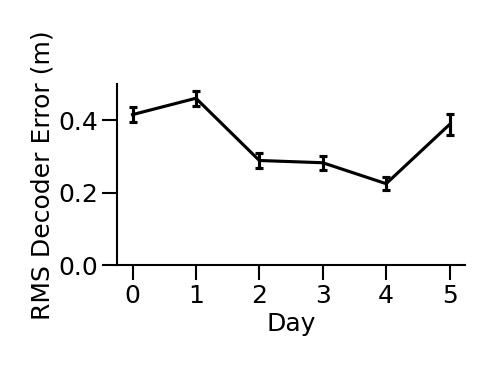

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(1.5, .8), dpi=300)
ax.errorbar(x=np.arange(6), y=rms_err_days_mean, yerr=rms_err_days_sem, c="black", **style.errorbar_style)
ax.set_xlabel("Day", **style.label_style)
ax.set_ylabel("RMS Decoder Error (m)", **style.label_style)
ax.set_ylim([0, .5])
ax.set_xticks(np.arange(6))
plotting_util.prettyify_ax(ax)

plt.savefig(FIG_DIR + "decoding_acc.svg", bbox_inches="tight")

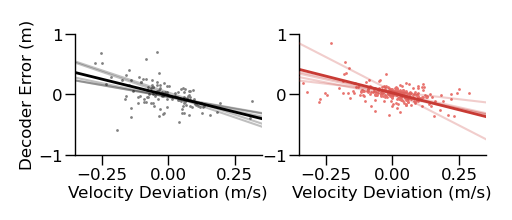

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(2.65, .8), dpi=200)
ax1, ax2 = axes
xlim = [-.35, .35]
ylim = [-1, 1]

for mouse_num in range(1, 6):
    ax1.scatter(avg_vel_deviations_mice_days[mouse_num-1, 0],
                avg_errs_mice_days[mouse_num-1, 0], c=style.day_0_color_light,
                s=1, lw=0, zorder=0)
    ax2.scatter(avg_vel_deviations_mice_days[mouse_num-1, 4],
                avg_errs_mice_days[mouse_num-1, 4], c=style.day_4_color_light,
                s=1, lw=0, zorder=0)
    plotting_util.plot_linregress_result(ax1, linregress_results_mice_days[mouse_num-1, 0],
                                         xlim, ylim, c=style.day_0_color, **style.line_style,
                                         alpha=.25, zorder=100)
    plotting_util.plot_linregress_result(ax2, linregress_results_mice_days[mouse_num-1, 4],
                                         xlim, ylim, c=style.day_4_color, **style.line_style,
                                         alpha=.25, zorder=100)
    
linregress_results_days = linregress_results_mice_days.mean(axis=0)
plotting_util.plot_linregress_result(ax1, linregress_results_days[0], xlim, ylim, c=style.day_0_color, lw=1.)
plotting_util.plot_linregress_result(ax2, linregress_results_days[4], xlim, ylim, c=style.day_4_color, lw=1.)

ax1.set_ylabel("Decoder Error (m)", **style.label_style)
for ax in axes:
    ax.set_xlabel("Velocity Deviation (m/s)", **style.label_style)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plotting_util.prettyify_ax(ax)

plt.savefig(FIG_DIR + "error_vs_velocity_deviation.svg", bbox_inches="tight")

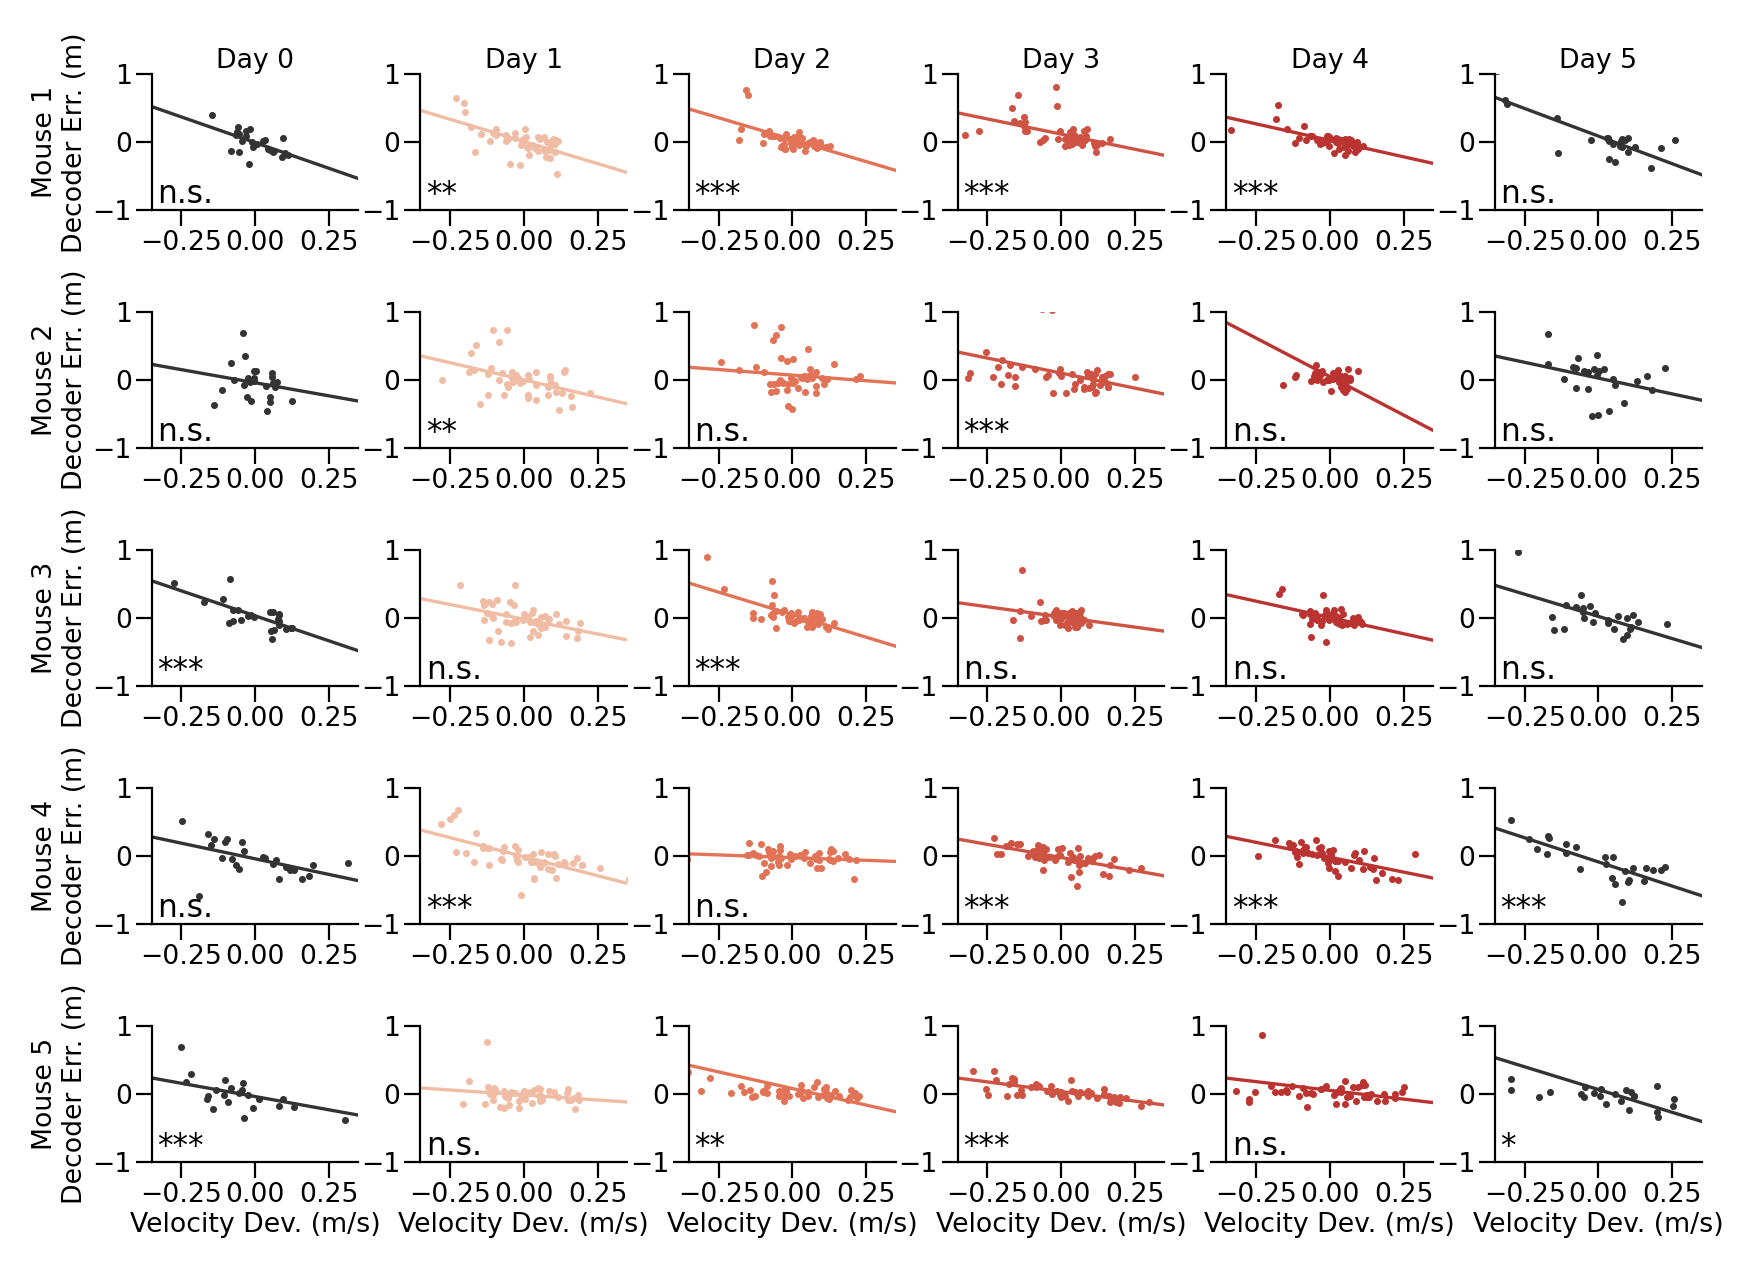

In [9]:
fig, axes = plt.subplots(5, 6, figsize=(6.25, 4.5), dpi=320)
fig.subplots_adjust(hspace=.75, wspace=.3)

xlim = [-.35, .35]
ylim = [-1, 1]
for mouse_num in range(1, 6):
    for day_num in range(6):
        ax = axes[mouse_num-1, day_num]
        lr = linregress_results_mice_days[mouse_num-1, day_num]
        ax.scatter(avg_vel_deviations_mice_days[mouse_num-1, day_num],
                   avg_errs_mice_days[mouse_num-1, day_num],
                   c=style.day_colors[day_num], **style.scatter_style)
        plotting_util.plot_linregress_result(ax, lr, xlim, ylim,
                                             c=style.day_colors[day_num], **style.line_style)
        if mouse_num == 1:
            ax.set_title("Day "+str(day_num), **style.title_style)
        if mouse_num == 5:
            ax.set_xlabel("Velocity Dev. (m/s)", **style.label_style)
        if day_num == 0:
            ax.set_ylabel("Mouse " + str(mouse_num) + "\nDecoder Err. (m)", **style.label_style)
        p_str = plotting_util.get_p_str(slope_p_vals[mouse_num-1, day_num]*30) #INCLUDE CORRECTION!
        ax.text(.025, 0, p_str, size=7, transform=ax.transAxes, ha="left", va="bottom")

for ax in axes.flatten():
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plotting_util.prettyify_ax(ax)
    
plt.savefig(FIG_DIR + "indiv_mouse_error_vs_velocity_deviation.svg", bbox_inches="tight")

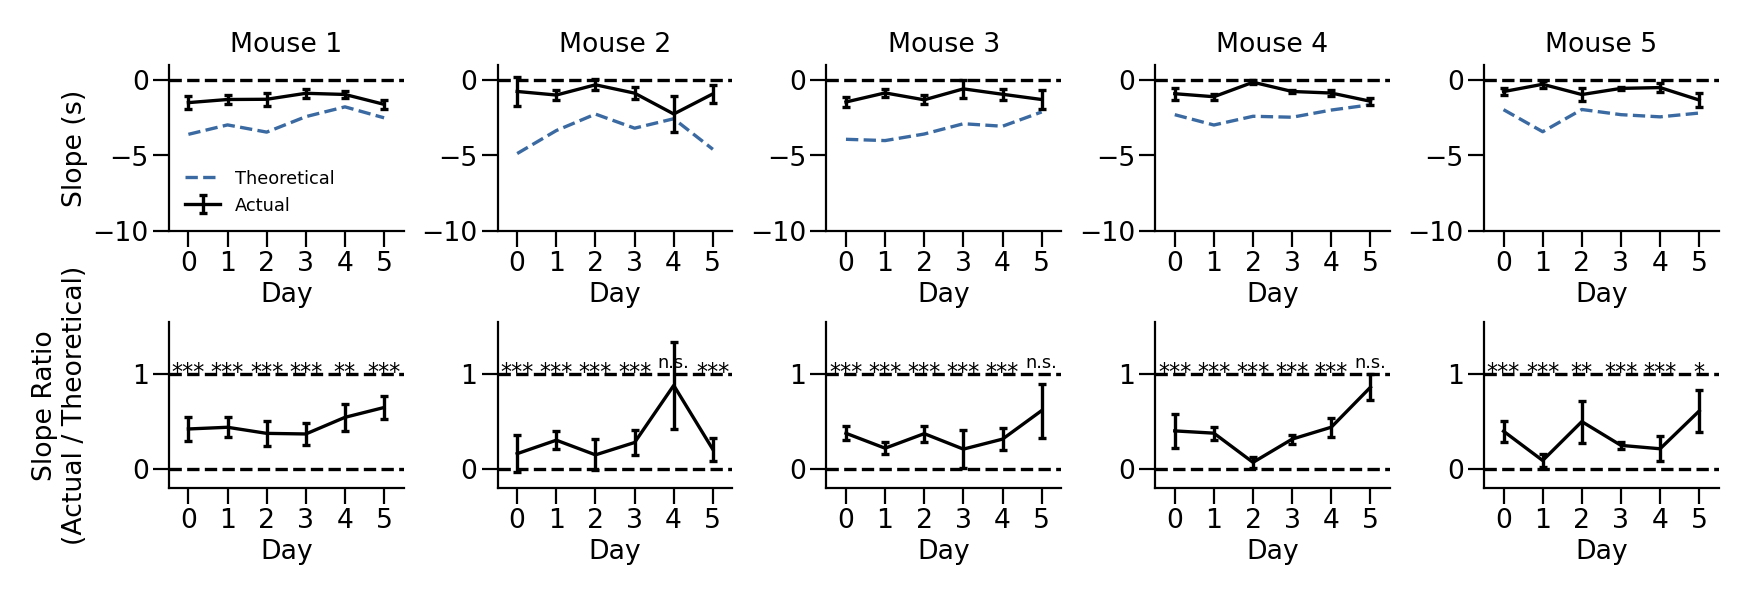

In [11]:
fig, axes = plt.subplots(2, 5, figsize=(6.25, 1.75), dpi=320)
fig.subplots_adjust(wspace=.4)
fig.subplots_adjust(hspace=.55)

for mouse_num in range(1, 6):
    i = mouse_num - 1
    ax = axes[0, i]
    ax.plot(np.arange(6), pred_slopes_mice_days[i], **style.line_style, c=style.pretty_blue, ls="--", label="Theoretical", zorder=0)
    ax.errorbar(x=np.arange(6), y=slopes_mice_days[i], yerr=slope_std_errs_mice_days[i], **style.errorbar_style, c="black", label="Actual", zorder=100)
    
    ax.set_ylim([-10, 1])
    ax.set_xlim([-.5, 5.5])
    ax.axhline(0, c="black", **style.line_style, ls="--")
    ax.set_xticks(np.arange(6))
    ax.set_xlabel("Day", **style.label_style)
    ax.set_title("Mouse " + str(mouse_num), pad=3, size=6)
    plotting_util.prettyify_ax(ax)
    
    ax = axes[1, i]
    ax.errorbar(x=np.arange(6), y=slope_ratios_mice_days[i], yerr=slope_ratio_std_errs_mice_days[i],
                **style.errorbar_style, c="black")
    for day_num in range(6):
        p_val = slope_ratio_unity_p_vals[mouse_num-1, day_num]
        p_str = plotting_util.get_p_str(p_val)
        y_val = 1.025 if p_str == "n.s." else .9
        size = 4 if p_str == "n.s." else 5
        ax.text(day_num, y_val, p_str, va="bottom", ha="center", size=size)

    ax.axhline(0, c="black", **style.line_style, ls="--")
    ax.axhline(1, c="black", **style.line_style, ls="--")
    ax.set_xlim([-.5, 5.5])
    ax.set_ylim([-.2, 1.55])
    ax.set_xticks(np.arange(6))
    ax.set_xlabel("Day", **style.label_style)
    plotting_util.prettyify_ax(ax)
    
axes[0, 0].set_ylabel("Slope (s)", **style.label_style)
axes[1, 0].set_ylabel("Slope Ratio\n(Actual / Theoretical)", **style.label_style)
axes[0, 0].legend(frameon=False, fontsize=4)
fig.align_ylabels(axes[:, 0])

plt.savefig(FIG_DIR + "slope_vs_pred_slopes.svg", bbox_inches="tight")

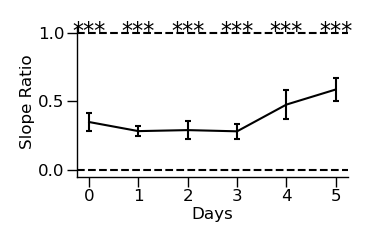

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(1.75, 1), dpi=200)

avg_slope_ratio = slope_ratios_mice_days.mean(axis=0)
avg_slope_std_err = np.sqrt(np.sum(slope_ratio_std_errs_mice_days**2, axis=0)) / 5.
ax.errorbar(x=np.arange(6), y=avg_slope_ratio, yerr=avg_slope_std_err, c="black", **style.errorbar_style)

ax.axhline(0, c="black", **style.line_style, ls="--")
ax.axhline(1, c="black", **style.line_style, ls="--")
ax.set_xticks(np.arange(6))
ax.set_xlabel("Days", **style.label_style)
ax.set_ylabel("Slope Ratio", **style.label_style)

for day_num in range(6):
    p_val = avg_slope_ratio_unity_p_vals[day_num]
    p_str = plotting_util.get_p_str(p_val)
    y_val = 1.1 if p_str == "n.s." else .925
    size = 6 if p_str == "n.s." else 8
    ax.text(day_num, y_val, p_str, va="bottom", ha="center", size=size)

plotting_util.prettyify_ax(ax)

plt.savefig(FIG_DIR + "avg_slope_ratio_vs_unity.svg", bbox_inches="tight")